Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

/Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,...,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,...,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [5]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [7]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline

In [8]:
#multi class classification problem
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
# import numpy as np
import numpy as np
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_mostly_zeros = ['num_private']
    X = X.drop(cols_mostly_zeros,axis=1)
    cols_with_zeros = ['amount_tsh', 'gps_height', 'longitude','population','construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop duplicates,and anything unecessary
    X = X.drop(['quantity_group','waterpoint_type_group'],axis=1)
    
    #eliminate categorical variabels that seem redundant based on importances below
    X = X.drop(['management_group','extraction_type_group','permit','payment','recorded_by'],axis=1)
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
test = wrangle(test)

In [10]:
#Feature Engineering 
def engineer_features(X):
    X = X.copy()
    X['quality_group_quantity'] = (X['water_quality']=='good') | (X['water_quality'] == 'quality_group')| (X['quantity'] == 'enough')
    X['water_quality_extraction_class'] = (X['water_quality'] == 'salty') & (X['extraction_type_class'] == 'other')
    X['quantity_dry_quality'] = (X['quantity']=='dry') | (X['water_quality'] == 'salty')
    X['construction_year_quality_insufficient'] = (X['quantity'] == 'insufficient') | (X['construction_year']<= 2004)
    X['construction_year_quality_sufficent'] = (X['quantity'] == 'sufficient') | (X['construction_year']>= 2004)
    return X
train = engineer_features(train)
test = engineer_features(test)
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,source,source_type,source_class,waterpoint_type,status_group,quality_group_quantity,water_quality_extraction_class,quantity_dry_quality,construction_year_quality_insufficient,construction_year_quality_sufficent
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,...,spring,spring,groundwater,communal standpipe,functional,True,False,False,True,False
1,8776,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,False,False,False,True,True
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,...,dam,dam,surface,communal standpipe multiple,functional,True,False,False,False,True
3,67743,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,...,machine dbh,borehole,groundwater,communal standpipe multiple,non functional,False,False,True,True,False
4,19728,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,False,False,False,False,False


In [11]:
#Data Filtering
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id, or other redunant features
train_features = train.drop(columns=[target, 'id',	'source_class'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 21].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features 
print(features)


['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'scheme_management', 'extraction_type', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'waterpoint_type', 'quality_group_quantity', 'water_quality_extraction_class', 'quantity_dry_quality', 'construction_year_quality_insufficient', 'construction_year_quality_sufficent']


In [12]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]
X_train.shape,y_train.shape,X_test.shape

((59400, 27), (59400,), (14358, 27))

In [13]:
RandomForestClassifier(min_samples_leaf=2,random_state = 42).get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [15]:
from sklearn.model_selection import RandomizedSearchCV
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100,150,200],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [0,5,10,20,37],
    'randomforestclassifier__min_samples_split': [0,5,10,36,100],
    'randomforestclassifier__min_samples_leaf': [1,2,10,20,40,50]
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_distributions,
    n_iter = 15,
    cv=3,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


Cross-validation Best Score 0.8048989898989899
Best Estimator: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'gini'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'extraction_type',
                                      'extraction_type_class', 'management',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Nyasa                 1
Lak

In [19]:


# Below is code i ran before the search cv, and performed a cross validation
#this method is more iterative, as appose to being automated as in searchcv
#I tweaked parameters by looking at different extremes of hyperparameters
#looking back the search cv can save time 
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(min_samples_leaf=2,
                           random_state=40,
                           min_samples_split = 10,
                           n_estimators = 200,
                           n_jobs = -1,
                           max_features = 5,
                           )

)
pipeline.fit(X_train,y_train)
k = 10
#for the scoring parameter use accuracy
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy',n_jobs = -1)
print(f'accuracy for {k} folds:', -scores)

accuracy for 10 folds: [-0.81632997 -0.81734007 -0.81094276 -0.80909091 -0.82323232 -0.80589226
 -0.81548822 -0.80538721 -0.80050505 -0.81734007]


In [27]:
#
#For the sake of understanding the k fold, I made a kfold w/. K = 10 and mean score is the following 
scores.mean()

#hyper parameters, min leaf1, 
#0.8056060606060607 150 estimators
#min leaf 2
#0.8124074074074074 80
#0.8130134680134681 100 *
#0.8131313131313131 120
#0.8133670033670034 150; estimators
#0.8129797979797981 200
#0.8128956228956229, 150 estimators, min leaf 2, removed X['water_quality_extraction_class']

0.8121548821548821

In [21]:
#Getting Feature Importances
#linear models have coefficients but trees have feature importances

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns=encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_,encoded_columns)
importances.sort_values(ascending=False)[:20]

longitude                 0.111311
latitude                  0.109035
quantity                  0.076187
quantity_dry_quality      0.071014
construction_year         0.059352
gps_height                0.056112
waterpoint_type           0.054695
extraction_type_class     0.053878
extraction_type           0.045922
population                0.039231
district_code             0.031628
payment_type              0.028858
quality_group_quantity    0.027856
region                    0.027736
region_code               0.026598
amount_tsh                0.025768
source                    0.024713
source_type               0.021462
basin                     0.020722
scheme_management         0.018709
dtype: float64

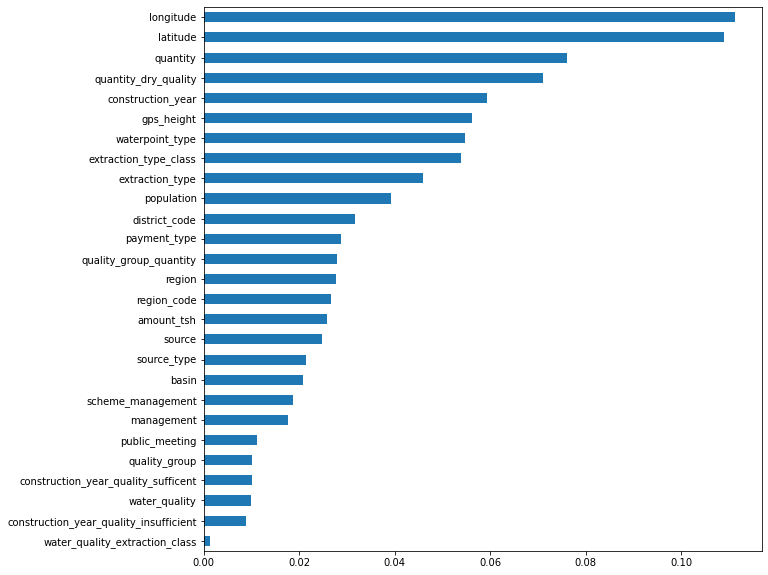

In [22]:
#plotting feature importances
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh()

In [25]:
#Submission to Kaggle
y_pred = pipeline.predict(X_test)

In [28]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)